In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import WeightedRandomSampler
from torchsampler import ImbalancedDatasetSampler


In [2]:
df = pd.read_csv('cleaned_dataset_YESNOADR_onehotalle_drugdesc.csv',index_col = False)

In [3]:
df

,ADR,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,Cohort ethnicity_Mongol,Drug_allopurinol,Drug_aspirin,Drug_carbamazepine,Drug_clozapine,Drug_co-trimoxazole,...,p2-53-M,p2-53-N,p2-53-P,p2-53-Q,p2-53-R,p2-53-S,p2-53-T,p2-53-V,p2-53-W,p2-53-Y
0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13090,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13091,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13092,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13093,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
df_input = df.iloc[:,1:]
df_target = df.iloc[:,0]

In [5]:
train_input, test_input, train_target, test_target = train_test_split(df_input, df_target, test_size=0.2, random_state=42, stratify = df_target)


In [6]:
print('train_label data distribution 0/1: {}/{}'.format(
len(np.where(train_target == 0)[0]), len(np.where(train_target == 1)[0])))

print('test_labels data distribution 0/1: {}/{}'.format(
len(np.where(test_target == 0)[0]), len(np.where(test_target == 1)[0])))

train_label data distribution 0/1: 6768/3708
test_labels data distribution 0/1: 1692/927


In [7]:
#calculate weight for each class in train_labels
weight = (1/pd.DataFrame(train_target).value_counts()).tolist()

#create weight array for train_labels
sample_weights = np.array([weight[int(t)] for t in train_target])

In [8]:
sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

In [9]:
train_dataset = TensorDataset(torch.from_numpy(train_input.values).float(),torch.from_numpy(train_target.values).float())
test_dataset = TensorDataset(torch.from_numpy(test_input.values).float(),torch.from_numpy(test_target.values).float())

In [11]:
train_loader = DataLoader(train_dataset, batch_size=256, sampler = sampler) #sampler = ImbalancedDatasetSampler(train_dataset))
test_loader= DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [12]:
def get_model():
    model = nn.Sequential(
        nn.Linear(train_loader.dataset.tensors[0].shape[1], 512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,64),
        nn.ReLU(),
        nn.Linear(64,1),
        nn.Sigmoid(),
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.BCELoss()

    return model,optimizer,loss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
device

device(type='cuda')

In [15]:
model,optimizer,loss_fn=get_model()
model = model.to(device)

In [16]:
writer = SummaryWriter()

EPOCHS = 100
allepoch_train_acc = []
allepoch_train_loss = []
allepoch_test_acc = []
allepoch_test_loss = []
allepoch_test_precision = []
allepoch_test_recall = []
allepoch_test_f1 = []
for epoch in range(EPOCHS):
        running_loss = []
        running_train_acc = []
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # # Limiting training data for faster epochs.
            # if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #     break


            data = data.float().to(device)
            target = target.float().to(device)

            optimizer.zero_grad()
            output = model(data)
            output = output.flatten()
            
            loss = loss_fn(output,target)
            loss.backward()
            optimizer.step()
    
            running_loss.append(loss.item()) 

            with torch.no_grad():
                target = target.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                train_acc = correct/len(target)
                train_acc = round(train_acc, 8)
                running_train_acc.append(train_acc)
        train_acc = np.mean(running_train_acc)

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # # Limiting validation data.
                # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #     break
                data = data.float().to(device)
                target = target.float().to(device)               
                output = model(data)
                output = output.flatten()
                data = data.flatten()
                output = torch.round(output)
                correct = (output == target).sum().item()
                test_loss = loss_fn(output, target)
                # # Get the index of the max log-probability.
                # pred = output.argmax(dim=1, keepdim=True)
                # correct += pred.eq(target.view_as(pred)).sum().item()
        #accuracy = correct/len(valid_loader.dataset)
            test_acc = correct / len(test_loader.dataset) #min(len(test_loader.dataset),N_VALID_EXAMPLES)
            train_loss = np.mean(running_loss)

            
            output = output.cpu().detach().numpy()
            target = target.cpu().detach().numpy()
            test_precision = precision_score(output, target, zero_division=0)
            test_f1_score = f1_score(output, target, zero_division=0)
            test_recall_score = recall_score(output, target, zero_division=0)
            test_loss = test_loss.cpu().detach().numpy()
            allepoch_train_acc.append(train_acc)
            allepoch_train_loss.append(train_loss)
            allepoch_test_acc.append(test_acc)
            allepoch_test_loss.append(test_loss)
            allepoch_test_precision.append(test_precision)
            allepoch_test_recall.append(test_recall_score)
            allepoch_test_f1.append(test_f1_score)
        print(f"{epoch}, Loss: {train_loss:.3f}, testloss: {test_loss:.3f} Train_Accuracy: {train_acc*100}, Test_Accuracy: {test_acc*100:.2f},test precision: {test_precision},test recall: {test_recall_score},test f1: {test_f1_score}")

        writer.add_scalars('Accuracy', {
            'train accuracy':train_loss*100,
            'test accuracy': test_acc*100
            }, epoch+1)
        

        writer.add_scalars('Loss', {
            'train loss':train_loss,
            'test loss': test_loss
            }, epoch+1)

0, Loss: 0.694, testloss: 64.605 Train_Accuracy: 49.81978607317073, Test_Accuracy: 35.40,test precision: 1.0,test recall: 0.3539518900343643,test f1: 0.5228426395939086
1, Loss: 0.693, testloss: 34.746 Train_Accuracy: 50.51205948780488, Test_Accuracy: 65.25,test precision: 0.16181229773462782,test recall: 0.5300353356890459,test f1: 0.24793388429752067
2, Loss: 0.691, testloss: 34.975 Train_Accuracy: 52.940910512195124, Test_Accuracy: 65.02,test precision: 0.05177993527508091,test recall: 0.5647058823529412,test f1: 0.09486166007905138
3, Loss: 0.689, testloss: 49.026 Train_Accuracy: 53.27743902439024, Test_Accuracy: 50.97,test precision: 0.7227615965480043,test recall: 0.394814378314673,test f1: 0.5106707317073171
4, Loss: 0.686, testloss: 48.988 Train_Accuracy: 54.16058417073171, Test_Accuracy: 51.01,test precision: 0.7227615965480043,test recall: 0.39504716981132076,test f1: 0.5108654212733511
5, Loss: 0.685, testloss: 49.026 Train_Accuracy: 54.28750904878049, Test_Accuracy: 50.97,t

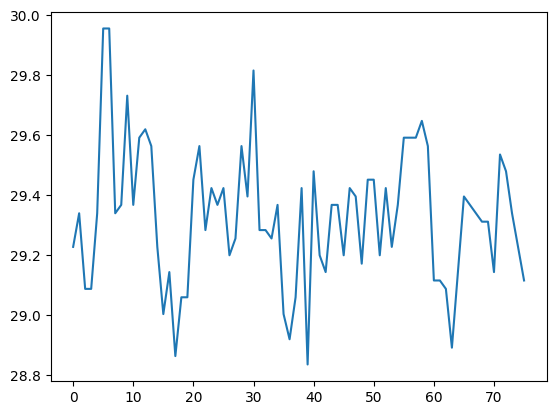

In [55]:
from matplotlib import pyplot as plt
plt.plot(allepoch_test_loss, label='train loss')

In [ ]:
train_loader.dataset.tensors[0]

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])